In [1]:
import qiskit
import numpy as np

from numpy import pi
from qiskit import BasicAer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram

%matplotlib inline

In [2]:
backend = BasicAer.get_backend('qasm_simulator')

## 1
Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.

In the function below, r_x and r_z are parameters to the circuit. Varying r_x and r_z changes the rotation on the x-axis and z-axis respectively which allows any point in the Bloch sphere to be reached.

In [5]:
def generate_qubit_state(rx_radians: float=None, rz_radians: float=None) -> Statevector:
    """Generates a general qubit state using Rx and Rz gates. Generates a random qubit state if no arguments are provided

    Args:
        r_x: Rotation in X-axis in radians. Defaults to random value
        r_z: Rotation in Z-axis in radians. Defaults to random value
    """
    if not rx_radians:
        rx_radians = np.random.uniform(-1,1) * pi
    if not rz_radians:
        rz_radians = np.random.uniform(-1,1) * pi
        
    # create circuit
    qreg_q = QuantumRegister(1, 'q')
    circuit = QuantumCircuit(qreg_q)

    # can also use a single U gate
    circuit.rx(rx_radians, qreg_q[0])
    circuit.rz(rz_radians, qreg_q[0])
    return Statevector.from_instruction(circuit)

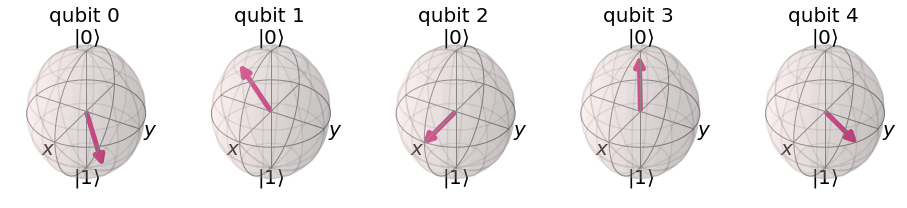

In [6]:
# generate 5 random qubit states and visualize bloch spheres
state = generate_qubit_state()
for _ in range(4):
    state = state.tensor(generate_qubit_state())
plot_bloch_multivector(state)

## 2
Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.

In [36]:
def swap_test(state_1: Statevector, state_2: Statevector, backend=backend, shots=1024) -> float:
    """Swap test: if state_1 and state_2 are orthogonal Pr(q[0]=0) = 1/2, otherwise if q[1] and q[2] are equal Pr(q[0]=0) = 1
    
    Args:
        state_1, state_2: single qubit states to be compared
        
    Returns:
        Pr(q[0]=0)
    """
    assert state_1.num_qubits == 1 and state_2.num_qubits == 1
    
    qreg_q = QuantumRegister(3, 'q')
    creg_c = ClassicalRegister(1, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    
    circuit.initialize(state_1.data, 1)
    circuit.initialize(state_2.data, 2)
    
    circuit.h(qreg_q[0])
    circuit.cswap(qreg_q[0], qreg_q[1], qreg_q[2])
    circuit.h(qreg_q[0])
    circuit.measure(qreg_q[0], creg_c[0])
    
    results = execute(circuit, backend=backend, shots=shots).result()
    answer = results.get_counts()
    return answer['0'] / shots

In [37]:
random_state = generate_qubit_state()

In [38]:
swap_test(random_state, Statevector([1,0]))

0.611328125

To reproduce a given qubit state using the 2 parameter variational circuit, I cast this as a minimization problem over rx_radians and rz_radians. Increasing the number of shots will increase the accuracy of the generated parameters

In [51]:
from scipy.optimize import minimize

In [52]:
def minimize_function_wrapper(params: np.ndarray, reference_state, shots=1024):
    return 1 - swap_test(reference_state, generate_qubit_state(params[0], params[1]), shots=shots)

In [75]:
results = minimize(minimize_function_wrapper, (0, 0), args=(random_state, 1024), 
                   method='Powell', bounds=((-pi, pi), (-pi, pi)))

In [76]:
results

   direc: array([[ 0.        ,  1.        ],
       [ 0.02924715, -0.00153307]])
     fun: array(0.)
 message: 'Optimization terminated successfully.'
    nfev: 154
     nit: 3
  status: 0
 success: True
       x: array([2.16723874, 0.69732299])

In [77]:
reproduced_state = generate_qubit_state(results.x[0], results.x[1])

In [78]:
swap_test(random_state, reproduced_state)

1.0

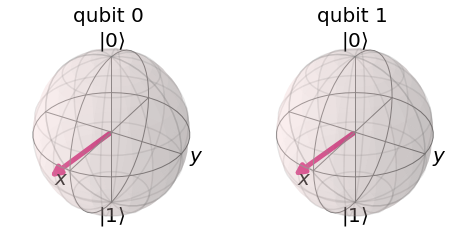

In [79]:
plot_bloch_multivector(random_state.tensor(reproduced_state))

## 3

In [80]:
# create function to generate n random qubit state

# create fn that takes in Statevector of product state and outputs a reconstructed state